# Analysis of Gamma-distributed Delays

## Gamma Distribution

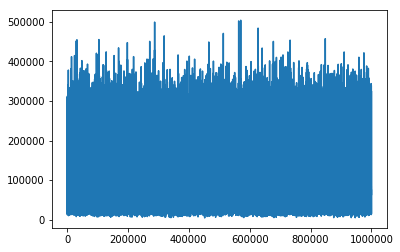

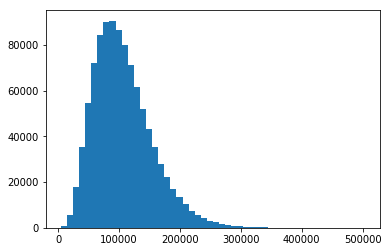

Theoretical mean: 1.070000e+05
Empirical mean: 1.070183e+05
Theoretical var: 2.289800e+09
Empirical var: 2.295394e+09


In [15]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

gamma_shape = 5
gamma_scale = 21400
n_samples   = int(1e6)
alpha       = 1.0

delay_ns = alpha*np.random.gamma(shape=gamma_shape,
                           scale=gamma_scale,
                           size=(n_samples, 1))

plt.figure()
plt.plot(delay_ns)
plt.show()

plt.figure()
plt.hist(delay_ns, bins=50)
plt.show()

mean_erlang = gamma_shape * gamma_scale
var_erlang  = gamma_shape * (gamma_scale**2)

print("Theoretical mean: %e" %(mean_erlang))
print("Empirical mean: %e" %(np.mean(delay_ns)))
print("Theoretical var: %e" %(var_erlang))
print("Empirical var: %e" %(np.var(delay_ns, ddof=1)))

### Variance Estimation

In PTP, we have: $$t_2 - t_1 = x + \kappa + \delta_{ms}$$, where $\kappa$ is the fixed part of the delay and $\delta_{ms}$ is the Gamma-distributed variable part of the delay (modelling queuing delay). What we have in order to estimate variance is the vector of observations of $t_2 - t_1$, so it is a vector of Gamma realizations plus a fixed offset.

Compare the variance estimation using the method from "A Recursive Method for Clock Synchronization in Asymmetric Packet-Based Networks" (by Hajikhani) with respect to the usual unbiased variance estimation:

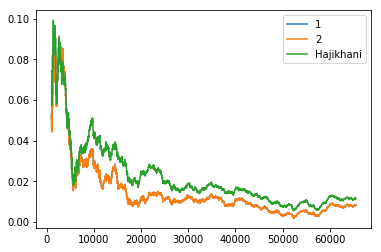

In [53]:
N_range = range(2**10, 2**16, 16) 
err_1   = np.zeros(len(N_range))
err_2   = np.zeros(len(N_range))
err_3   = np.zeros(len(N_range))

x_plus_kappa = 2000
theo_var     = gamma_shape * (gamma_scale**2) # Theoretical variance
    
for i,N in enumerate(N_range):
    observations = x_plus_kappa + delay_ns[1:N]                 # Add the fixed offset
    var_est_1 = np.var(observations)                            # Conventional estimate
    var_est_2 = np.var(observations, ddof=1)                    # Conventional (unbiased) estimate
    var_est_3 = np.mean(np.diff(observations, axis=0)**2) / 2   # Estimate from the above paper
    err_1[i]  = var_est_1 - theo_var
    err_2[i]  = var_est_2 - theo_var
    err_3[i]  = var_est_3 - theo_var
    
plt.figure()
plt.plot(N_range, np.abs(err_1) / theo_var, label='1')
plt.plot(N_range, np.abs(err_2) / theo_var, label='2')
plt.plot(N_range, np.abs(err_3) / theo_var, label='Hajikhani')
plt.legend()
plt.show()


Does not seem to help very much. And the variance estimation seems to be biased.

### Parameter estimation

The goal is to find the shape and scale parameters. Try the Wikipedia approach below:

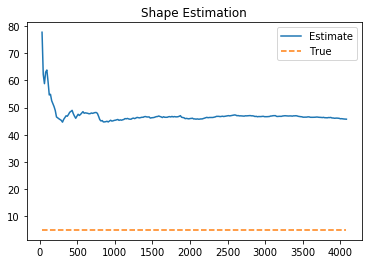

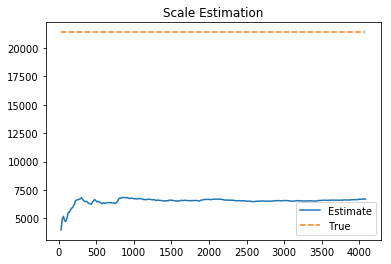

In [69]:
N_range   = range(2**5, 2**12, 16) 
shape_est = np.zeros(len(N_range))
scale_est = np.zeros(len(N_range))
    
x_plus_kappa = 200000

for i,N in enumerate(N_range):
    # Observations
    x = x_plus_kappa + delay_ns[1:N]
    
    # From wikipedia
    s = np.log(np.mean(x)) - np.mean(np.log(x))
    
    # Shape:
    k = (3 - s + np.sqrt((s - 3)**2 + 24*s))/(12*s)
    
    # Scale
    theta = np.mean(x) / k
    
    shape_est[i] = k
    scale_est[i] = theta
    
plt.figure()
plt.plot(N_range, shape_est, label='Estimate')
plt.plot(N_range, gamma_shape*np.ones(len(N_range)), label='True', linestyle='dashed')
plt.legend()
plt.title('Shape Estimation')
plt.show()

plt.figure()
plt.plot(N_range, scale_est, label='Estimate')
plt.plot(N_range, gamma_scale*np.ones(len(N_range)), label='True', linestyle='dashed')
plt.legend()
plt.title('Scale Estimation')
plt.show()

## Gamma difference distribution 

For time offset and frequency offset measurements.

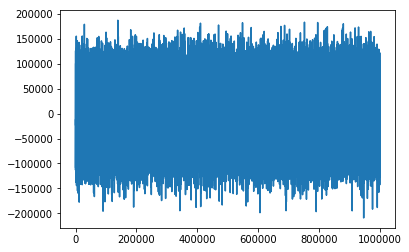

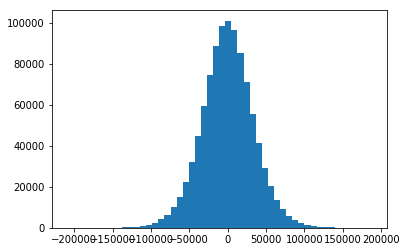

Empirical mean: 2.240379e+01
Theoretical x_tilde var: 1.144900e+09
Empirical x_tilde var: 1.140730e+09
Theoretical y_tilde var: 1.172378e-10
Empirical y_tilde var: 1.172628e-10
Theoretical mean(abs(x_tilde)^2) var: 1.144846e+09
Empirical mean(abs(x_tilde)^2) var: 1.140729e+09


In [2]:
N                 = 100
sync_period       = (1.0/16)
sync_period_ns    = sync_period * 1e9
k                 = 5
theta             = 21400

delay_1_ns  = np.random.gamma(shape=k,
                              scale=theta,
                              size=(n_samples,1))
delay_2_ns  = np.random.gamma(shape=k,
                              scale=theta,
                              size=(n_samples,1))
delay_3_ns  = np.random.gamma(shape=k,
                              scale=theta,
                              size=(n_samples,1))
delay_4_ns  = np.random.gamma(shape=k,
                              scale=theta,
                              size=(n_samples,1))

x_tilde = (delay_1_ns - delay_2_ns)/2
y_tilde = (delay_3_ns - delay_4_ns)/(N * sync_period_ns)

plt.figure()
plt.plot(x_tilde)
plt.show()

plt.figure()
plt.hist(x_tilde, bins=50)
plt.show()

var_erlang = k * (theta**2)

print("Empirical mean: %e" %(np.mean(x_tilde)))
print("Theoretical x_tilde var: %e" %(0.5 * var_erlang))
print("Empirical x_tilde var: %e" %(np.var(x_tilde, ddof=1)))
print("Theoretical y_tilde var: %e" %(2 * var_erlang /((N * sync_period_ns)**2)))
print("Empirical y_tilde var: %e" %(np.var(y_tilde, ddof=1)))
print("Theoretical mean(abs(x_tilde)^2) var: %e" %(0.5*(k*(theta**2) - (k*theta))))
print("Empirical mean(abs(x_tilde)^2) var: %e" %(np.mean(np.square(np.abs(x_tilde)))))

## Gamma Sum

For two-way delay measurements.

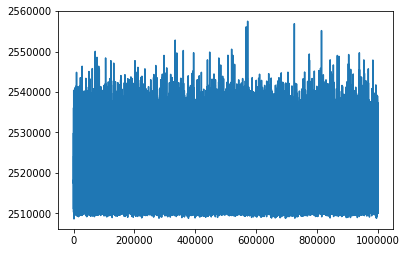

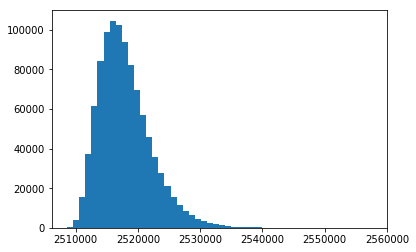

In [14]:
N                 = 100
sync_period       = (1.0/16)
sync_period_ns    = sync_period * 1e9
k1                = 5
theta1            = 2000
bias1             = 16000
k2                = 2
theta2            = 5000
bias2             = 5000

delay_1_ns = bias1 + np.random.gamma(shape=k1,
                             scale=theta1,
                             size=(n_samples,1))
delay_2_ns = bias2 + np.random.gamma(shape=k2,
                             scale=theta2,
                             size=(n_samples,1))

d_tilde = (delay_1_ns + delay_2_ns)/2


plt.figure()
plt.plot(d_tilde)
plt.show()

plt.figure()
plt.hist(d_tilde, bins=50)
plt.show()

## Erlang using numpy.choice

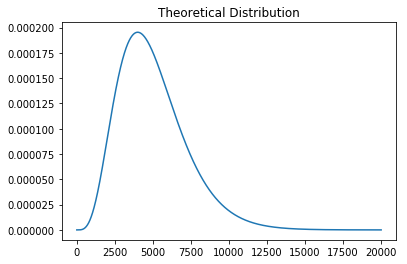

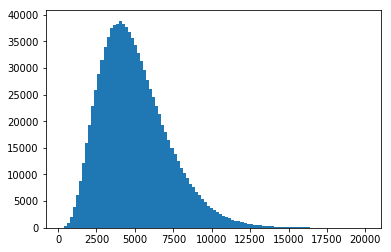

In [113]:
k         = 5    # shape
mu        = 1000  # scale
lamb      = 1/mu # rate
max_val   = 20000
n_samples = 1000000

x   = np.arange(0, max_val, 1.0)
fx  = ((lamb**k)/np.math.factorial(k-1)) * (x ** (k-1)) * (np.exp(-lamb*x))
fx /= fx.sum()

plt.figure()
plt.plot(x, fx)
plt.title('Theoretical Distribution')
plt.show()

samples = np.random.choice(max_val, n_samples, p=fx)

plt.figure()
plt.hist(samples, bins=100)
plt.show()

## Miorrered Erlang using numpy.choice

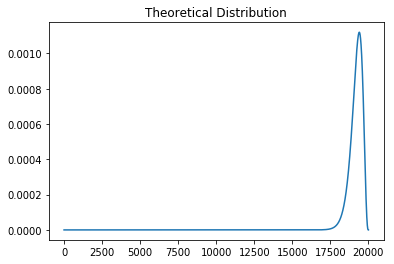

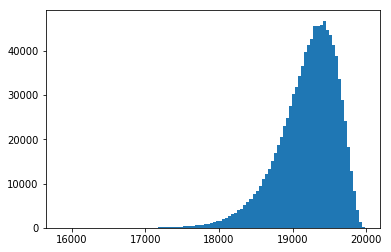

In [114]:
k         = 4    # shape
mu        = 200  # scale
lamb      = 1/mu # rate
max_val   = 20000
n_samples = 1000000

x   = np.arange(0, max_val, 1.0)
fx  = ((lamb**k)/np.math.factorial(k-1)) * (x ** (k-1)) * (np.exp(-lamb*x))
fx /= fx.sum()
fx  = np.flip(fx)

plt.figure()
plt.plot(x, fx)
plt.title('Theoretical Distribution')
plt.show()

samples = np.random.choice(max_val, n_samples, p=fx)

plt.figure()
plt.hist(samples, bins=100)
plt.show()

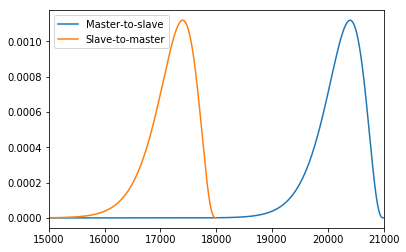

In [128]:
k         = 4    # shape
mu        = 200  # scale
lamb      = 1/mu # rate
max_val_1 = 21000

x = np.arange(0, max_val_1, 1.0)

fx  = ((lamb**k)/np.math.factorial(k-1)) * (x ** (k-1)) * (np.exp(-lamb*x))
fx /= fx.sum()
fx  = np.flip(fx)

fx_ms = fx

plt.figure()
plt.plot(x, fx_ms, label="Master-to-slave")

max_val_2 = 18000

x   = np.arange(0, max_val_2, 1.0)
fx  = ((lamb**k)/np.math.factorial(k-1)) * (x ** (k-1)) * (np.exp(-lamb*x))
fx /= fx.sum()
fx  = np.flip(fx)

fx_sm = fx

plt.plot(x, fx_sm, label="Slave-to-master")
plt.xlim([15000, 21000])
plt.legend()
plt.show()